In [12]:
# Copyright (c) 2024 Byeonghyeon Kim 
# github site: https://github.com/bhkim003/ByeonghyeonKim
# email: bhkim003@snu.ac.kr
 
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:
 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


In [13]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import time

from snntorch import spikegen
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

from tqdm import tqdm

from apex.parallel import DistributedDataParallel as DDP

import random
import datetime

import json

In [14]:
# my module import
from modules import *

# modules 폴더에 새모듈.py 만들면
# modules/__init__py 파일에 form .새모듈 import * 하셈
# 그리고 새모듈.py에서 from modules.새모듈 import * 하셈


In [15]:
def my_snn_system(devices = "0,1,2,3",
                    my_seed = 42,
                    TIME = 8,
                    BATCH = 256,
                    IMAGE_SIZE = 32,
                    which_data = 'CIFAR10',
                    CLASS_NUM = 10,
                    data_path = '/data2',
                    rate_coding = True,
    
                    lif_layer_v_init = 0.0,
                    lif_layer_v_decay = 0.6,
                    lif_layer_v_threshold = 1.2,
                    lif_layer_v_reset = 0.0,
                    lif_layer_sg_width = 1,

                    # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                    synapse_conv_kernel_size = 3,
                    synapse_conv_stride = 1,
                    synapse_conv_padding = 1,
                    synapse_conv_trace_const1 = 1,
                    synapse_conv_trace_const2 = 0.6,

                    # synapse_fc_out_features = CLASS_NUM,
                    synapse_fc_trace_const1 = 1,
                    synapse_fc_trace_const2 = 0.6,

                    pre_trained = False,
                    convTrue_fcFalse = True,
                    cfg = [64, 64],
                    net_print = False, # True # False
                    pre_trained_path = "net_save/save_now_net.pth",
                    learning_rate = 0.0001,
                    epoch_num = 200,
                    verbose_interval = 100, #숫자 크게 하면 꺼짐
                    validation_interval = 10, #숫자 크게 하면 꺼짐
                    tdBN_on = False,
                    BN_on = False,

                    surrogate = 'sigmoid',

                    gradient_verbose = False,

                    BPTT_on = False,

                    optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                    scheduler_name = 'no',
                    
                    ddp_on = True,

                    nda_net = False,
                  ):
    # 함수 내 모든 로컬 변수 저장
    hyperparameters = locals()
    hyperparameters['top_train_acc_one_iter'] = 0
    hyperparameters['top_val_acc'] = 0
    hyperparameters['current epoch'] = 0

    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
    os.environ["CUDA_VISIBLE_DEVICES"]= devices

    
    torch.manual_seed(my_seed)


    
    # data loader, pixel channel, class num
    train_loader, test_loader, synapse_conv_in_channels = data_loader(
            which_data,
            data_path, 
            rate_coding, 
            BATCH, 
            IMAGE_SIZE,
            ddp_on)
    synapse_fc_out_features = CLASS_NUM


    ## parameter number calculator ##########################################
    params_num = 0
    img_size = IMAGE_SIZE 
    bias_param = 1 # 1 or 0
    classifier_making = False
    if (convTrue_fcFalse == True):
        past_kernel = synapse_conv_in_channels
        for kernel in cfg:
            if (classifier_making == False):
                if (type(kernel) == list):
                    for residual_kernel in kernel:
                        params_num += residual_kernel * ((synapse_conv_kernel_size**2) * past_kernel + bias_param)
                        past_kernel = residual_kernel
                elif (kernel == 'P' or kernel == 'M'):
                    img_size = img_size // 2
                elif (kernel == 'L'):
                    classifier_making = True
                    past_kernel = past_kernel * (img_size**2)
                else:
                    params_num += kernel * (synapse_conv_kernel_size**2 * past_kernel + bias_param)
                    past_kernel = kernel    
            else: # classifier making
                params_num += (past_kernel + bias_param) * kernel
                past_kernel = kernel
        
        
        if classifier_making == False:
            past_kernel = past_kernel*img_size*img_size

        params_num += (past_kernel + bias_param) * synapse_fc_out_features
    else:
        past_in_channel = synapse_conv_in_channels*img_size*img_size
        for in_channel in cfg:
            if (type(in_channel) == list):
                for residual_in_channel in in_channel:
                    params_num += (past_in_channel + bias_param) * residual_in_channel
                    past_in_channel = residual_in_channel
            # elif (in_channel == 'M'): #it's a holy FC layer!
            #     img_size = img_size // 2
            else:
                params_num += (past_in_channel + bias_param) * in_channel
                past_in_channel = in_channel
        params_num += (past_in_channel + bias_param) * synapse_fc_out_features
    ## parameter number calculator ##########################################


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if pre_trained == False:
        if (convTrue_fcFalse == False):
            net = MY_SNN_FC(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                     synapse_fc_trace_const1, synapse_fc_trace_const2, 
                     lif_layer_v_init, lif_layer_v_decay, 
                     lif_layer_v_threshold, lif_layer_v_reset,
                     lif_layer_sg_width,
                     tdBN_on,
                     BN_on, TIME,
                     surrogate,
                     BPTT_on).to(device)
        else:
            net = MY_SNN_CONV(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                     synapse_conv_kernel_size, synapse_conv_stride, 
                     synapse_conv_padding, synapse_conv_trace_const1, 
                     synapse_conv_trace_const2, 
                     lif_layer_v_init, lif_layer_v_decay, 
                     lif_layer_v_threshold, lif_layer_v_reset,
                     lif_layer_sg_width,
                     synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                     tdBN_on,
                     BN_on, TIME,
                     surrogate,
                     BPTT_on).to(device)
        
        if (nda_net == True):
            net = VGG(cfg = cfg, num_classes=10, batch_norm = tdBN_on, in_c = synapse_conv_in_channels, 
                      lif_layer_v_threshold=lif_layer_v_threshold, lif_layer_v_decay=lif_layer_v_decay, lif_layer_sg_width=lif_layer_sg_width)
            net.T = TIME
        net = torch.nn.DataParallel(net)
    else:
        net = torch.load(pre_trained_path)


    net = net.to(device)
    if (net_print == True):
        print(net)
    
    ## param num and memory estimation except BN at MY calculation ##########################################
    real_param_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
    # Batch norm 있으면 아래 두 개 서로 다를 수 있음.
    # assert real_param_num == params_num, f'parameter number is not same. real_param_num: {real_param_num}, params_num: {params_num}'    
    print('='*50)
    print(f"My Num of PARAMS: {params_num:,}, system's param_num : {real_param_num:,}")
    memory = params_num / 8 / 1024 / 1024 # MB
    precision = 32
    memory = memory * precision 
    print(f"Memory: {memory:.2f}MiB at {precision}-bit")
    print('='*50)
    ##########################################################################

    criterion = nn.CrossEntropyLoss().to(device)
    
    if(optimizer_what == 'SGD'):
        # optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
        optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0)
    elif(optimizer_what == 'Adam'):
        # optimizer = torch.optim.Adam(net.parameters(), lr=0.00001)
        # optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate/256 * BATCH, weight_decay=1e-4)
        optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0, betas=(0.9, 0.999))
    elif(optimizer_what == 'RMSprop'):
        pass


    if (scheduler_name == 'StepLR'):
        scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    elif (scheduler_name == 'ExponentialLR'):
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    elif (scheduler_name == 'ReduceLROnPlateau'):
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
    elif (scheduler_name == 'CosineAnnealingLR'):
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=50)
    elif (scheduler_name == 'OneCycleLR'):
        scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=100)
    else:
        pass # 'no' scheduler

    val_acc = 0
    val_acc_now = 0
    elapsed_time_val = 0
    train_acc_array = np.array([])
    val_acc_now_array = np.array([])
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    for epoch in range(epoch_num):
        print('EPOCH', epoch)
        epoch_start_time = time.time()
        running_loss = 0.0
        
        iterator = enumerate(train_loader, 0)
        if (ddp_on == True):
            if torch.distributed.get_rank() == 0:   
                iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)
        else:
            iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)

        for i, data in iterator:
            iter_one_train_time_start = time.time()
            net.train()

            ## data loading #################################
            inputs, labels = data

            
            if (which_data == 'DVS-CIFAR10'):
                inputs = inputs.permute(1, 0, 2, 3, 4)
            elif rate_coding == True :
                inputs = spikegen.rate(inputs, num_steps=TIME)
            else :
                inputs = inputs.repeat(TIME, 1, 1, 1, 1)
            # inputs: [Time, Batch, Channel, Height, Width]  
            ################################################# 

            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # inputs: [Time, Batch, Channel, Height, Width]   
            inputs = inputs.permute(1, 0, 2, 3, 4) # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매
            # inputs: [Batch, Time, Channel, Height, Width]   
        
            outputs = net(inputs)

            batch = BATCH 
            if labels.size(0) != BATCH: 
                batch = labels.size(0)

            


            ####### training accruacy print ###############################
            correct = 0
            total = 0
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted[0:batch] == labels).sum().item()
            train_acc = correct / total
            if i % verbose_interval == verbose_interval-1:
                print(f'{epoch}-{i} training acc: {100 * train_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}, val_acc: {100 * val_acc_now:.2f}%')
            training_acc_string = f'{epoch}-{i}/{len(train_loader)} tr_acc: {100 * correct / total:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}'
            
            ################################################################
            

            loss = criterion(outputs[0:batch,:], labels)
            loss.backward()


            ### gradinet verbose ##########################################
            if (gradient_verbose == True):
                if (i % verbose_interval == verbose_interval-1):
                    print('\n\nepoch', epoch, 'iter', i)
                    for name, param in net.named_parameters():
                        if param.requires_grad:
                            print('\n\n\n\n' , name, param.grad)
            ################################################################
            
            optimizer.step()

            running_loss += loss.item()
            # print("Epoch: {}, Iter: {}, Loss: {}".format(epoch + 1, i + 1, running_loss / 100))

            iter_one_train_time_end = time.time()
            elapsed_time = iter_one_train_time_end - iter_one_train_time_start  # 실행 시간 계산

            if (i % verbose_interval == verbose_interval-1):
                print(f"iter_one_train_time: {elapsed_time} seconds, last one_val_time: {elapsed_time_val} seconds\n")

            ##### validation ##############################################
            if i % validation_interval == validation_interval-1:
                iter_one_val_time_start = time.time()
                
                correct = 0
                total = 0
                with torch.no_grad():
                    net.eval()
                    for data in test_loader:
                        ## data loading #################################
                        inputs, labels = data

                        
                        if (which_data == 'DVS-CIFAR10'):
                            inputs = inputs.permute(1, 0, 2, 3, 4)
                        elif rate_coding == True :
                            inputs = spikegen.rate(inputs, num_steps=TIME)
                        else :
                            inputs = inputs.repeat(TIME, 1, 1, 1, 1)
                        # inputs: [Time, Batch, Channel, Height, Width]  
                        ################################################# 

                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        outputs = net(inputs.permute(1, 0, 2, 3, 4))
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        batch = BATCH 
                        if labels.size(0) != BATCH: 
                            batch = labels.size(0)
                        correct += (predicted[0:batch] == labels).sum().item()
                        val_loss = criterion(outputs[0:batch,:], labels)

                    val_acc_now = correct / total
                    # print(f'{epoch}-{i} validation acc: {100 * val_acc_now:.2f}%, lr={[f"{lr:.10f}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}')

                iter_one_val_time_end = time.time()
                elapsed_time_val = iter_one_val_time_end - iter_one_val_time_start  # 실행 시간 계산
                # print(f"iter_one_val_time: {elapsed_time_val} seconds")

                # network save
                if val_acc < val_acc_now:
                    val_acc = val_acc_now
                    torch.save(net.state_dict(), "net_save/save_now_net_weights.pth")
                    torch.save(net, "net_save/save_now_net.pth")
                    torch.save(net.module.state_dict(), "net_save/save_now_net_weights2.pth")
                    torch.save(net.module, "net_save/save_now_net2.pth")
            ################################################################
            iterator.set_description(f"train: {training_acc_string}, tr_loss: {loss}, val_acc: {100 * val_acc_now:.2f}%")  

            train_acc_array = np.append(train_acc_array, train_acc)
            val_acc_now_array = np.append(val_acc_now_array, val_acc_now)
            base_name = f'{current_time}'
            train_acc_file_name = f'result_save/{base_name}_train_acc_array.npy'
            val_acc_file_name = f'result_save/{base_name}_val_acc_now_array.npy'
            hyperparameters_file_name = f'result_save/{base_name}_hyperparameters.json'

            if(train_acc > hyperparameters['top_train_acc_one_iter']):
                hyperparameters['top_train_acc_one_iter'] = train_acc
            if(val_acc_now > hyperparameters['top_val_acc']):
                hyperparameters['top_val_acc'] = val_acc_now
            hyperparameters['current epoch'] = epoch

            np.save(train_acc_file_name, train_acc_array)
            np.save(val_acc_file_name, val_acc_now_array)
            with open(hyperparameters_file_name, 'w') as f:
                json.dump(hyperparameters, f, indent=4)

            np.save('result_save/train_acc_array.npy', train_acc_array)
            np.save('result_save/val_acc_now_array.npy', val_acc_now_array)
            with open('result_save/hyperparameters.json', 'w') as f:
                json.dump(hyperparameters, f, indent=4)
            
        if (scheduler_name != 'no'):
            if (scheduler_name == 'ReduceLROnPlateau'):
                scheduler.step(val_loss)
            else:
                scheduler.step()

        
        
        epoch_time_end = time.time()
        epoch_time = epoch_time_end - epoch_start_time  # 실행 시간 계산
        
        print(f"epoch_time: {epoch_time} seconds")
        print('\n')


In [16]:
### my_snn control board ########################
decay = 0.5 # 0.875 0.25 0.125 0.75 0.5
# nda 0.25 # ottt 0.5

my_snn_system(  devices = "0,1,2,3,4,5",
                my_seed = 42,
                TIME = 10, # dvscifar 10 # ottt 6 or 10 # nda 10
                BATCH = 128, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
                IMAGE_SIZE = 48, # dvscifar 48 # MNIST 28 # CIFAR10 32

                # DVS-CIFAR10 할거면 time 10으로 해라
                which_data = 'DVS-CIFAR10',# 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS-CIFAR10'
                CLASS_NUM = 10,
                data_path = '/data2', # YOU NEED TO CHANGE THIS
                rate_coding = False, # True # False

                lif_layer_v_init = 0.0,
                lif_layer_v_decay = decay,
                lif_layer_v_threshold = 1.0, # nda 0.5  # ottt 1.0
                lif_layer_v_reset = 0.0, #현재 안씀. 걍 빼기 해버림
                lif_layer_sg_width = 1.0, # surrogate sigmoid 쓸 때는 의미없음

                # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                synapse_conv_kernel_size = 3,
                synapse_conv_stride = 1,
                synapse_conv_padding = 1,
                synapse_conv_trace_const1 = 1,
                synapse_conv_trace_const2 = decay, # lif_layer_v_decay

                # synapse_fc_out_features = CLASS_NUM,
                synapse_fc_trace_const1 = 1,
                synapse_fc_trace_const2 = decay, # lif_layer_v_decay

                pre_trained = False, # True # False
                convTrue_fcFalse = True, # True # False

                # 'P' for average pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
                # cfg = [64],
                # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], 
                cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], # ottt 
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],


                net_print = False, # True # False
                pre_trained_path = "net_save/save_now_net.pth",
                learning_rate = 0.001,  # ottt 0.1  # nda 0.001
                epoch_num = 200,
                verbose_interval = 9999999999, #숫자 크게 하면 꺼짐
                validation_interval = 50, #숫자 크게 하면 꺼짐
                tdBN_on = True,  # True # False
                BN_on = False,  # True # False
                
                surrogate = 'sigmoid', # 'rectangle' 'sigmoid' 'rough_rectangle'
                
                gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

                BPTT_on = True,  # True # False # True이면 BPTT, False이면 OTTT
                optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
                ddp_on = False,   # True # False

                nda_net = False,   # True # False
                ) 
# sigmoid와 BN이 있어야 잘된다.
# average pooling이 낫다.

# nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


My Num of PARAMS: 9,404,234, system's param_num : 9,409,738
Memory: 35.87MiB at 32-bit
EPOCH 0


train: 0-70/71 tr_acc: 35.00%, lr=['0.001'], tr_loss: 1.7473218441009521, val_acc: 30.10%: 100%|██████████| 71/71 [00:52<00:00,  1.35it/s]

epoch_time: 53.08960795402527 seconds


EPOCH 1



train: 1-70/71 tr_acc: 47.50%, lr=['0.0009990133642141358'], tr_loss: 1.5573744773864746, val_acc: 31.60%: 100%|██████████| 71/71 [00:42<00:00,  1.69it/s]

epoch_time: 42.33959984779358 seconds


EPOCH 2



train: 2-70/71 tr_acc: 47.50%, lr=['0.000996057350657239'], tr_loss: 1.559213399887085, val_acc: 40.00%: 100%|██████████| 71/71 [00:42<00:00,  1.69it/s] 

epoch_time: 42.4198739528656 seconds


EPOCH 3



train: 3-70/71 tr_acc: 57.50%, lr=['0.0009911436253643444'], tr_loss: 1.3615577220916748, val_acc: 46.70%: 100%|██████████| 71/71 [00:42<00:00,  1.69it/s]

epoch_time: 42.43639421463013 seconds


EPOCH 4



train: 4-70/71 tr_acc: 42.50%, lr=['0.0009842915805643156'], tr_loss: 1.4137585163116455, val_acc: 44.60%: 100%|██████████| 71/71 [00:41<00:00,  1.70it/s]

epoch_time: 42.026758432388306 seconds


EPOCH 5



train: 5-70/71 tr_acc: 50.00%, lr=['0.0009755282581475769'], tr_loss: 1.3014028072357178, val_acc: 43.60%: 100%|██████████| 71/71 [00:41<00:00,  1.70it/s]

epoch_time: 42.15316939353943 seconds


EPOCH 6



train: 6-70/71 tr_acc: 50.00%, lr=['0.0009648882429441258'], tr_loss: 1.3006231784820557, val_acc: 48.00%: 100%|██████████| 71/71 [00:42<00:00,  1.67it/s]

epoch_time: 42.85158634185791 seconds


EPOCH 7



train: 7-70/71 tr_acc: 52.50%, lr=['0.0009524135262330099'], tr_loss: 1.3736131191253662, val_acc: 47.80%: 100%|██████████| 71/71 [00:41<00:00,  1.71it/s]

epoch_time: 41.70423865318298 seconds


EPOCH 8



train: 8-70/71 tr_acc: 40.00%, lr=['0.0009381533400219318'], tr_loss: 1.651563286781311, val_acc: 45.70%: 100%|██████████| 71/71 [00:41<00:00,  1.71it/s] 

epoch_time: 41.96134090423584 seconds


EPOCH 9



train: 9-70/71 tr_acc: 65.00%, lr=['0.0009221639627510075'], tr_loss: 1.3003027439117432, val_acc: 45.70%: 100%|██████████| 71/71 [00:41<00:00,  1.70it/s]

epoch_time: 42.10569381713867 seconds


EPOCH 10



train: 10-70/71 tr_acc: 60.00%, lr=['0.0009045084971874736'], tr_loss: 1.3492389917373657, val_acc: 49.40%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s]

epoch_time: 42.57907032966614 seconds


EPOCH 11



train: 11-70/71 tr_acc: 57.50%, lr=['0.0008852566213878945'], tr_loss: 1.2866661548614502, val_acc: 53.20%: 100%|██████████| 71/71 [00:42<00:00,  1.67it/s]

epoch_time: 42.74956297874451 seconds


EPOCH 12



train: 12-70/71 tr_acc: 45.00%, lr=['0.0008644843137107056'], tr_loss: 1.4358915090560913, val_acc: 52.20%: 100%|██████████| 71/71 [00:41<00:00,  1.70it/s]

epoch_time: 42.14414930343628 seconds


EPOCH 13



train: 13-70/71 tr_acc: 57.50%, lr=['0.0008422735529643443'], tr_loss: 1.1939916610717773, val_acc: 54.60%: 100%|██████████| 71/71 [00:42<00:00,  1.67it/s]

epoch_time: 42.844752073287964 seconds


EPOCH 14



train: 14-70/71 tr_acc: 60.00%, lr=['0.0008187119948743448'], tr_loss: 1.190710186958313, val_acc: 59.30%: 100%|██████████| 71/71 [00:42<00:00,  1.67it/s] 

epoch_time: 42.757238149642944 seconds


EPOCH 15



train: 15-70/71 tr_acc: 52.50%, lr=['0.0007938926261462366'], tr_loss: 1.3789393901824951, val_acc: 58.30%: 100%|██████████| 71/71 [00:41<00:00,  1.71it/s]

epoch_time: 41.88753294944763 seconds


EPOCH 16



train: 16-70/71 tr_acc: 55.00%, lr=['0.0007679133974894982'], tr_loss: 1.195788860321045, val_acc: 45.50%: 100%|██████████| 71/71 [00:41<00:00,  1.71it/s] 

epoch_time: 41.81006050109863 seconds


EPOCH 17



train: 17-70/71 tr_acc: 50.00%, lr=['0.0007408768370508576'], tr_loss: 1.2893550395965576, val_acc: 56.60%: 100%|██████████| 71/71 [00:41<00:00,  1.70it/s]

epoch_time: 42.145299434661865 seconds


EPOCH 18



train: 18-70/71 tr_acc: 65.00%, lr=['0.0007128896457825362'], tr_loss: 0.9813657999038696, val_acc: 60.10%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s]

epoch_time: 42.51255655288696 seconds


EPOCH 19



train: 19-70/71 tr_acc: 72.50%, lr=['0.0006840622763423389'], tr_loss: 1.0137676000595093, val_acc: 45.40%: 100%|██████████| 71/71 [00:42<00:00,  1.69it/s]

epoch_time: 42.39461135864258 seconds


EPOCH 20



train: 20-70/71 tr_acc: 70.00%, lr=['0.0006545084971874735'], tr_loss: 1.0423773527145386, val_acc: 61.10%: 100%|██████████| 71/71 [00:42<00:00,  1.66it/s]


epoch_time: 43.18451714515686 seconds


EPOCH 21


train: 21-70/71 tr_acc: 62.50%, lr=['0.0006243449435824271'], tr_loss: 1.000510334968567, val_acc: 57.50%: 100%|██████████| 71/71 [00:41<00:00,  1.70it/s] 

epoch_time: 42.09138607978821 seconds


EPOCH 22



train: 22-70/71 tr_acc: 55.00%, lr=['0.0005936906572928622'], tr_loss: 1.1652129888534546, val_acc: 61.70%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s]

epoch_time: 42.51286745071411 seconds


EPOCH 23



train: 23-70/71 tr_acc: 62.50%, lr=['0.000562666616782152'], tr_loss: 0.9398101568222046, val_acc: 56.80%: 100%|██████████| 71/71 [00:42<00:00,  1.69it/s]

epoch_time: 42.303619384765625 seconds


EPOCH 24



train: 24-70/71 tr_acc: 55.00%, lr=['0.0005313952597646566'], tr_loss: 1.2038772106170654, val_acc: 60.60%: 100%|██████████| 71/71 [00:42<00:00,  1.69it/s]

epoch_time: 42.40989661216736 seconds


EPOCH 25



train: 25-70/71 tr_acc: 70.00%, lr=['0.0004999999999999998'], tr_loss: 0.9197033643722534, val_acc: 55.70%: 100%|██████████| 71/71 [00:41<00:00,  1.71it/s]

epoch_time: 41.837167739868164 seconds


EPOCH 26



train: 26-70/71 tr_acc: 65.00%, lr=['0.00046860474023534314'], tr_loss: 1.1345512866973877, val_acc: 59.50%: 100%|██████████| 71/71 [00:41<00:00,  1.71it/s]

epoch_time: 41.772621393203735 seconds


EPOCH 27



train: 27-70/71 tr_acc: 70.00%, lr=['0.00043733338321784774'], tr_loss: 0.992599368095398, val_acc: 58.10%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s] 

epoch_time: 42.52089858055115 seconds


EPOCH 28



train: 28-70/71 tr_acc: 72.50%, lr=['0.00040630934270713756'], tr_loss: 0.805627167224884, val_acc: 57.80%: 100%|██████████| 71/71 [00:41<00:00,  1.71it/s] 

epoch_time: 41.91783857345581 seconds


EPOCH 29



train: 29-70/71 tr_acc: 57.50%, lr=['0.00037565505641757246'], tr_loss: 1.233135461807251, val_acc: 63.00%: 100%|██████████| 71/71 [00:42<00:00,  1.67it/s] 

epoch_time: 42.86566138267517 seconds


EPOCH 30



train: 30-70/71 tr_acc: 70.00%, lr=['0.00034549150281252633'], tr_loss: 0.8720742464065552, val_acc: 57.60%: 100%|██████████| 71/71 [00:41<00:00,  1.70it/s]

epoch_time: 42.20977306365967 seconds


EPOCH 31



train: 31-70/71 tr_acc: 77.50%, lr=['0.00031593772365766105'], tr_loss: 0.7774292230606079, val_acc: 63.10%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s]

epoch_time: 42.58866357803345 seconds


EPOCH 32



train: 32-70/71 tr_acc: 75.00%, lr=['0.00028711035421746355'], tr_loss: 0.8061453700065613, val_acc: 63.20%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s]

epoch_time: 42.537909269332886 seconds


EPOCH 33



train: 33-70/71 tr_acc: 77.50%, lr=['0.0002591231629491422'], tr_loss: 0.7153831720352173, val_acc: 65.10%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s]

epoch_time: 42.666011095047 seconds


EPOCH 34



train: 34-70/71 tr_acc: 70.00%, lr=['0.00023208660251050145'], tr_loss: 1.1015352010726929, val_acc: 63.30%: 100%|██████████| 71/71 [00:42<00:00,  1.69it/s]

epoch_time: 42.351813554763794 seconds


EPOCH 35



train: 35-70/71 tr_acc: 65.00%, lr=['0.00020610737385376337'], tr_loss: 0.8847650289535522, val_acc: 61.00%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s]

epoch_time: 42.6808123588562 seconds


EPOCH 36



train: 36-70/71 tr_acc: 65.00%, lr=['0.00018128800512565502'], tr_loss: 1.2702362537384033, val_acc: 65.10%: 100%|██████████| 71/71 [00:41<00:00,  1.69it/s]

epoch_time: 42.2282874584198 seconds


EPOCH 37



train: 37-70/71 tr_acc: 72.50%, lr=['0.00015772644703565555'], tr_loss: 0.8648061752319336, val_acc: 65.20%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s]

epoch_time: 42.649781465530396 seconds


EPOCH 38



train: 38-70/71 tr_acc: 67.50%, lr=['0.00013551568628929425'], tr_loss: 0.7195481657981873, val_acc: 64.90%: 100%|██████████| 71/71 [00:41<00:00,  1.70it/s]

epoch_time: 41.97617053985596 seconds


EPOCH 39



train: 39-70/71 tr_acc: 72.50%, lr=['0.00011474337861210535'], tr_loss: 0.7006186842918396, val_acc: 63.70%: 100%|██████████| 71/71 [00:41<00:00,  1.70it/s]

epoch_time: 42.104358434677124 seconds


EPOCH 40



train: 40-70/71 tr_acc: 70.00%, lr=['9.549150281252626e-05'], tr_loss: 0.7053574919700623, val_acc: 66.50%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s]

epoch_time: 42.575263261795044 seconds


EPOCH 41



train: 41-70/71 tr_acc: 60.00%, lr=['7.783603724899252e-05'], tr_loss: 0.9387445449829102, val_acc: 66.70%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s]

epoch_time: 42.636191606521606 seconds


EPOCH 42



train: 42-70/71 tr_acc: 70.00%, lr=['6.184665997806817e-05'], tr_loss: 0.843676745891571, val_acc: 66.80%: 100%|██████████| 71/71 [00:42<00:00,  1.67it/s] 

epoch_time: 42.826961517333984 seconds


EPOCH 43



train: 43-70/71 tr_acc: 67.50%, lr=['4.7586473766990294e-05'], tr_loss: 0.9543040990829468, val_acc: 67.00%: 100%|██████████| 71/71 [00:42<00:00,  1.66it/s]

epoch_time: 43.11128640174866 seconds


EPOCH 44



train: 44-70/71 tr_acc: 65.00%, lr=['3.5111757055874305e-05'], tr_loss: 1.021984577178955, val_acc: 67.30%: 100%|██████████| 71/71 [00:42<00:00,  1.69it/s] 


epoch_time: 42.30261254310608 seconds


EPOCH 45


train: 45-70/71 tr_acc: 72.50%, lr=['2.4471741852423218e-05'], tr_loss: 0.8339444994926453, val_acc: 66.10%: 100%|██████████| 71/71 [00:41<00:00,  1.71it/s]

epoch_time: 41.84441304206848 seconds


EPOCH 46



train: 46-70/71 tr_acc: 72.50%, lr=['1.5708419435684507e-05'], tr_loss: 0.8831619024276733, val_acc: 67.00%: 100%|██████████| 71/71 [00:41<00:00,  1.69it/s]

epoch_time: 42.27102184295654 seconds


EPOCH 47



train: 47-70/71 tr_acc: 72.50%, lr=['8.856374635655634e-06'], tr_loss: 0.7590880990028381, val_acc: 67.20%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s]

epoch_time: 42.62714886665344 seconds


EPOCH 48



train: 48-70/71 tr_acc: 77.50%, lr=['3.942649342761115e-06'], tr_loss: 0.8187252879142761, val_acc: 66.90%: 100%|██████████| 71/71 [00:41<00:00,  1.71it/s]

epoch_time: 41.854241132736206 seconds


EPOCH 49



train: 49-70/71 tr_acc: 62.50%, lr=['9.866357858642198e-07'], tr_loss: 1.091232180595398, val_acc: 67.70%: 100%|██████████| 71/71 [00:41<00:00,  1.69it/s] 

epoch_time: 42.2386257648468 seconds


EPOCH 50



train: 50-70/71 tr_acc: 72.50%, lr=['0.0'], tr_loss: 0.8342159390449524, val_acc: 67.90%: 100%|██████████| 71/71 [00:42<00:00,  1.67it/s]

epoch_time: 42.738282918930054 seconds


EPOCH 51



train: 51-70/71 tr_acc: 80.00%, lr=['9.866357858642206e-07'], tr_loss: 0.7912265062332153, val_acc: 67.50%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s]

epoch_time: 42.56200432777405 seconds


EPOCH 52



train: 52-70/71 tr_acc: 77.50%, lr=['3.942649342761062e-06'], tr_loss: 0.7814368009567261, val_acc: 66.90%: 100%|██████████| 71/71 [00:41<00:00,  1.69it/s]

epoch_time: 42.24116086959839 seconds


EPOCH 53



train: 53-70/71 tr_acc: 80.00%, lr=['8.856374635655695e-06'], tr_loss: 0.7038865089416504, val_acc: 66.20%: 100%|██████████| 71/71 [00:41<00:00,  1.72it/s]

epoch_time: 41.6537401676178 seconds


EPOCH 54



train: 54-70/71 tr_acc: 75.00%, lr=['1.5708419435684406e-05'], tr_loss: 0.7962362170219421, val_acc: 66.80%: 100%|██████████| 71/71 [00:41<00:00,  1.71it/s]

epoch_time: 41.736032485961914 seconds


EPOCH 55



train: 55-70/71 tr_acc: 65.00%, lr=['2.4471741852423177e-05'], tr_loss: 1.0238112211227417, val_acc: 67.20%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s]

epoch_time: 42.64984607696533 seconds


EPOCH 56



train: 56-70/71 tr_acc: 77.50%, lr=['3.5111757055874265e-05'], tr_loss: 0.6620138883590698, val_acc: 66.90%: 100%|██████████| 71/71 [00:42<00:00,  1.69it/s]

epoch_time: 42.40591478347778 seconds


EPOCH 57



train: 57-70/71 tr_acc: 55.00%, lr=['4.7586473766990145e-05'], tr_loss: 1.2253514528274536, val_acc: 67.00%: 100%|██████████| 71/71 [00:41<00:00,  1.70it/s]

epoch_time: 42.08626461029053 seconds


EPOCH 58



train: 58-70/71 tr_acc: 65.00%, lr=['6.184665997806825e-05'], tr_loss: 0.9344994425773621, val_acc: 66.60%: 100%|██████████| 71/71 [00:41<00:00,  1.70it/s]

epoch_time: 42.03061771392822 seconds


EPOCH 59



train: 59-70/71 tr_acc: 62.50%, lr=['7.78360372489924e-05'], tr_loss: 1.0748727321624756, val_acc: 65.30%: 100%|██████████| 71/71 [00:41<00:00,  1.70it/s]

epoch_time: 42.10660243034363 seconds


EPOCH 60



train: 60-70/71 tr_acc: 62.50%, lr=['9.54915028125261e-05'], tr_loss: 0.9288649559020996, val_acc: 65.20%: 100%|██████████| 71/71 [00:41<00:00,  1.69it/s]

epoch_time: 42.29817509651184 seconds


EPOCH 61



train: 61-70/71 tr_acc: 70.00%, lr=['0.00011474337861210537'], tr_loss: 0.8764942288398743, val_acc: 67.10%: 100%|██████████| 71/71 [00:41<00:00,  1.69it/s]

epoch_time: 42.22623872756958 seconds


EPOCH 62



train: 62-70/71 tr_acc: 67.50%, lr=['0.0001355156862892941'], tr_loss: 1.0429902076721191, val_acc: 64.90%: 100%|██████████| 71/71 [00:42<00:00,  1.67it/s]

epoch_time: 42.80045175552368 seconds


EPOCH 63



train: 63-70/71 tr_acc: 65.00%, lr=['0.00015772644703565566'], tr_loss: 0.9817261695861816, val_acc: 63.00%: 100%|██████████| 71/71 [00:41<00:00,  1.70it/s]

epoch_time: 42.195735692977905 seconds


EPOCH 64



train: 64-70/71 tr_acc: 70.00%, lr=['0.00018128800512565518'], tr_loss: 0.7558505535125732, val_acc: 65.30%: 100%|██████████| 71/71 [00:41<00:00,  1.69it/s]

epoch_time: 42.234962463378906 seconds


EPOCH 65



train: 65-70/71 tr_acc: 70.00%, lr=['0.00020610737385376332'], tr_loss: 0.9487496614456177, val_acc: 63.10%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s]

epoch_time: 42.473549365997314 seconds


EPOCH 66



train: 66-70/71 tr_acc: 77.50%, lr=['0.00023208660251050178'], tr_loss: 0.7345864772796631, val_acc: 62.30%: 100%|██████████| 71/71 [00:41<00:00,  1.71it/s]

epoch_time: 41.68264937400818 seconds


EPOCH 67



train: 67-70/71 tr_acc: 70.00%, lr=['0.00025912316294914234'], tr_loss: 0.9626449346542358, val_acc: 62.90%: 100%|██████████| 71/71 [00:41<00:00,  1.70it/s]

epoch_time: 41.98921513557434 seconds


EPOCH 68



train: 68-70/71 tr_acc: 85.00%, lr=['0.0002871103542174638'], tr_loss: 0.5409225821495056, val_acc: 63.00%: 100%|██████████| 71/71 [00:41<00:00,  1.70it/s]

epoch_time: 42.16834235191345 seconds


EPOCH 69



train: 69-70/71 tr_acc: 65.00%, lr=['0.000315937723657661'], tr_loss: 1.0015878677368164, val_acc: 57.80%: 100%|██████████| 71/71 [00:41<00:00,  1.70it/s]

epoch_time: 42.13844633102417 seconds


EPOCH 70



train: 70-70/71 tr_acc: 72.50%, lr=['0.0003454915028125261'], tr_loss: 0.9962928891181946, val_acc: 62.60%: 100%|██████████| 71/71 [00:41<00:00,  1.69it/s]

epoch_time: 42.310890913009644 seconds


EPOCH 71



train: 71-70/71 tr_acc: 75.00%, lr=['0.0003756550564175727'], tr_loss: 0.8853021860122681, val_acc: 63.60%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s]

epoch_time: 42.46703600883484 seconds


EPOCH 72



train: 72-70/71 tr_acc: 57.50%, lr=['0.0004063093427071376'], tr_loss: 1.0972354412078857, val_acc: 60.90%: 100%|██████████| 71/71 [00:41<00:00,  1.69it/s]

epoch_time: 42.22813415527344 seconds


EPOCH 73



train: 73-70/71 tr_acc: 55.00%, lr=['0.0004373333832178476'], tr_loss: 1.1605820655822754, val_acc: 53.40%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s]

epoch_time: 42.597999811172485 seconds


EPOCH 74



train: 74-70/71 tr_acc: 80.00%, lr=['0.00046860474023534325'], tr_loss: 0.720805287361145, val_acc: 62.50%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s] 

epoch_time: 42.54983949661255 seconds


EPOCH 75



train: 75-70/71 tr_acc: 70.00%, lr=['0.0004999999999999998'], tr_loss: 0.7800813913345337, val_acc: 48.00%: 100%|██████████| 71/71 [00:41<00:00,  1.69it/s]

epoch_time: 42.222251653671265 seconds


EPOCH 76



train: 76-70/71 tr_acc: 75.00%, lr=['0.0005313952597646563'], tr_loss: 0.7585238814353943, val_acc: 54.40%: 100%|██████████| 71/71 [00:41<00:00,  1.70it/s]

epoch_time: 42.02453422546387 seconds


EPOCH 77



train: 77-70/71 tr_acc: 75.00%, lr=['0.0005626666167821521'], tr_loss: 0.7592971920967102, val_acc: 59.20%: 100%|██████████| 71/71 [00:41<00:00,  1.69it/s]

epoch_time: 42.25674033164978 seconds


EPOCH 78



train: 78-70/71 tr_acc: 75.00%, lr=['0.0005936906572928622'], tr_loss: 0.6573980450630188, val_acc: 57.60%: 100%|██████████| 71/71 [00:42<00:00,  1.67it/s]

epoch_time: 42.895439863204956 seconds


EPOCH 79



train: 79-70/71 tr_acc: 77.50%, lr=['0.0006243449435824275'], tr_loss: 0.6534626483917236, val_acc: 59.50%: 100%|██████████| 71/71 [00:41<00:00,  1.71it/s]

epoch_time: 41.8418664932251 seconds


EPOCH 80



train: 80-70/71 tr_acc: 80.00%, lr=['0.0006545084971874736'], tr_loss: 0.6876169443130493, val_acc: 56.20%: 100%|██████████| 71/71 [00:42<00:00,  1.67it/s]

epoch_time: 42.726555585861206 seconds


EPOCH 81



train: 81-70/71 tr_acc: 70.00%, lr=['0.0006840622763423388'], tr_loss: 0.9567532539367676, val_acc: 56.30%: 100%|██████████| 71/71 [00:41<00:00,  1.70it/s]

epoch_time: 42.10663437843323 seconds


EPOCH 82



train: 82-70/71 tr_acc: 62.50%, lr=['0.000712889645782536'], tr_loss: 0.9434536695480347, val_acc: 59.20%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s]

epoch_time: 42.540916442871094 seconds


EPOCH 83



train: 83-70/71 tr_acc: 70.00%, lr=['0.0007408768370508579'], tr_loss: 0.8153653144836426, val_acc: 62.20%: 100%|██████████| 71/71 [00:41<00:00,  1.70it/s]

epoch_time: 42.03735637664795 seconds


EPOCH 84



train: 84-70/71 tr_acc: 67.50%, lr=['0.0007679133974894985'], tr_loss: 0.9501527547836304, val_acc: 54.40%: 100%|██████████| 71/71 [00:41<00:00,  1.69it/s]

epoch_time: 42.25520944595337 seconds


EPOCH 85



train: 85-70/71 tr_acc: 72.50%, lr=['0.0007938926261462367'], tr_loss: 0.8086175918579102, val_acc: 52.00%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s]

epoch_time: 42.56718945503235 seconds


EPOCH 86



train: 86-70/71 tr_acc: 72.50%, lr=['0.0008187119948743449'], tr_loss: 0.7324670553207397, val_acc: 56.70%: 100%|██████████| 71/71 [00:41<00:00,  1.69it/s]

epoch_time: 42.271958351135254 seconds


EPOCH 87



train: 87-70/71 tr_acc: 65.00%, lr=['0.0008422735529643442'], tr_loss: 1.0721850395202637, val_acc: 59.20%: 100%|██████████| 71/71 [00:42<00:00,  1.67it/s]

epoch_time: 42.69327449798584 seconds


EPOCH 88



train: 88-70/71 tr_acc: 75.00%, lr=['0.0008644843137107058'], tr_loss: 0.8109153509140015, val_acc: 57.00%: 100%|██████████| 71/71 [00:42<00:00,  1.67it/s]

epoch_time: 42.92401051521301 seconds


EPOCH 89



train: 89-70/71 tr_acc: 72.50%, lr=['0.000885256621387895'], tr_loss: 0.8782219886779785, val_acc: 57.80%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s]

epoch_time: 42.51104688644409 seconds


EPOCH 90



train: 90-70/71 tr_acc: 72.50%, lr=['0.000904508497187474'], tr_loss: 0.8130776286125183, val_acc: 61.80%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s]

epoch_time: 42.396941900253296 seconds


EPOCH 91



train: 91-70/71 tr_acc: 80.00%, lr=['0.0009221639627510078'], tr_loss: 0.6733505725860596, val_acc: 58.20%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s]

epoch_time: 42.5341637134552 seconds


EPOCH 92



train: 92-70/71 tr_acc: 75.00%, lr=['0.0009381533400219319'], tr_loss: 0.7261783480644226, val_acc: 39.40%: 100%|██████████| 71/71 [00:41<00:00,  1.70it/s]

epoch_time: 42.08925151824951 seconds


EPOCH 93



train: 93-70/71 tr_acc: 57.50%, lr=['0.00095241352623301'], tr_loss: 0.8262980580329895, val_acc: 57.20%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s]

epoch_time: 42.47635865211487 seconds


EPOCH 94



train: 94-70/71 tr_acc: 77.50%, lr=['0.000964888242944126'], tr_loss: 0.5492790937423706, val_acc: 64.30%: 100%|██████████| 71/71 [00:42<00:00,  1.67it/s]

epoch_time: 42.900710105895996 seconds


EPOCH 95



train: 95-70/71 tr_acc: 77.50%, lr=['0.000975528258147577'], tr_loss: 0.7072506546974182, val_acc: 55.30%: 100%|██████████| 71/71 [00:41<00:00,  1.70it/s]

epoch_time: 42.075753927230835 seconds


EPOCH 96



train: 96-70/71 tr_acc: 87.50%, lr=['0.0009842915805643156'], tr_loss: 0.547225832939148, val_acc: 60.80%: 100%|██████████| 71/71 [00:41<00:00,  1.70it/s] 

epoch_time: 42.147972106933594 seconds


EPOCH 97



train: 97-70/71 tr_acc: 82.50%, lr=['0.0009911436253643444'], tr_loss: 0.622808575630188, val_acc: 60.20%: 100%|██████████| 71/71 [00:41<00:00,  1.70it/s] 

epoch_time: 42.00296092033386 seconds


EPOCH 98



train: 98-70/71 tr_acc: 75.00%, lr=['0.0009960573506572388'], tr_loss: 0.7734864950180054, val_acc: 58.40%: 100%|██████████| 71/71 [00:42<00:00,  1.69it/s]

epoch_time: 42.30366325378418 seconds


EPOCH 99



train: 99-70/71 tr_acc: 85.00%, lr=['0.0009990133642141358'], tr_loss: 0.6105707287788391, val_acc: 52.10%: 100%|██████████| 71/71 [00:42<00:00,  1.67it/s]

epoch_time: 42.69177484512329 seconds


EPOCH 100



train: 100-70/71 tr_acc: 77.50%, lr=['0.001'], tr_loss: 0.6073273420333862, val_acc: 54.90%: 100%|██████████| 71/71 [00:41<00:00,  1.70it/s]

epoch_time: 42.01519584655762 seconds


EPOCH 101



train: 101-70/71 tr_acc: 67.50%, lr=['0.0009990133642141358'], tr_loss: 0.7957429885864258, val_acc: 59.90%: 100%|██████████| 71/71 [00:42<00:00,  1.69it/s] 

epoch_time: 42.364009618759155 seconds


EPOCH 102



train: 102-70/71 tr_acc: 75.00%, lr=['0.000996057350657239'], tr_loss: 0.7338269352912903, val_acc: 66.80%: 100%|██████████| 71/71 [00:41<00:00,  1.69it/s]

epoch_time: 42.22931957244873 seconds


EPOCH 103



train: 103-70/71 tr_acc: 90.00%, lr=['0.0009911436253643444'], tr_loss: 0.4152867794036865, val_acc: 59.60%: 100%|██████████| 71/71 [00:41<00:00,  1.70it/s] 

epoch_time: 42.04594683647156 seconds


EPOCH 104



train: 104-70/71 tr_acc: 80.00%, lr=['0.0009842915805643156'], tr_loss: 0.6823352575302124, val_acc: 62.50%: 100%|██████████| 71/71 [00:41<00:00,  1.70it/s] 

epoch_time: 42.17524433135986 seconds


EPOCH 105



train: 105-70/71 tr_acc: 75.00%, lr=['0.0009755282581475769'], tr_loss: 0.7071546316146851, val_acc: 64.10%: 100%|██████████| 71/71 [00:41<00:00,  1.70it/s] 

epoch_time: 42.02510929107666 seconds


EPOCH 106



train: 106-70/71 tr_acc: 80.00%, lr=['0.0009648882429441258'], tr_loss: 0.5545920133590698, val_acc: 65.20%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s]

epoch_time: 42.528846740722656 seconds


EPOCH 107



train: 107-70/71 tr_acc: 82.50%, lr=['0.0009524135262330099'], tr_loss: 0.5205681324005127, val_acc: 62.30%: 100%|██████████| 71/71 [00:42<00:00,  1.67it/s] 

epoch_time: 42.84175682067871 seconds


EPOCH 108



train: 108-70/71 tr_acc: 72.50%, lr=['0.000938153340021932'], tr_loss: 0.8199443817138672, val_acc: 63.40%: 100%|██████████| 71/71 [00:41<00:00,  1.70it/s] 

epoch_time: 42.134703159332275 seconds


EPOCH 109



train: 109-70/71 tr_acc: 80.00%, lr=['0.0009221639627510078'], tr_loss: 0.6159222722053528, val_acc: 62.30%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s] 

epoch_time: 42.67580485343933 seconds


EPOCH 110



train: 110-70/71 tr_acc: 67.50%, lr=['0.0009045084971874736'], tr_loss: 0.7550877332687378, val_acc: 64.70%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s] 

epoch_time: 42.63073396682739 seconds


EPOCH 111



train: 111-70/71 tr_acc: 60.00%, lr=['0.0008852566213878944'], tr_loss: 1.021057367324829, val_acc: 64.50%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s]  

epoch_time: 42.43916416168213 seconds


EPOCH 112



train: 112-70/71 tr_acc: 72.50%, lr=['0.0008644843137107057'], tr_loss: 0.7219375371932983, val_acc: 55.20%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s] 

epoch_time: 42.5195095539093 seconds


EPOCH 113



train: 113-70/71 tr_acc: 72.50%, lr=['0.0008422735529643445'], tr_loss: 0.7320026755332947, val_acc: 59.60%: 100%|██████████| 71/71 [00:41<00:00,  1.69it/s] 

epoch_time: 42.25234866142273 seconds


EPOCH 114



train: 114-70/71 tr_acc: 80.00%, lr=['0.000818711994874345'], tr_loss: 0.5986924171447754, val_acc: 60.00%: 100%|██████████| 71/71 [00:42<00:00,  1.67it/s] 

epoch_time: 42.812445640563965 seconds


EPOCH 115



train: 115-70/71 tr_acc: 85.00%, lr=['0.0007938926261462362'], tr_loss: 0.5306848883628845, val_acc: 58.40%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s] 

epoch_time: 42.425761461257935 seconds


EPOCH 116



train: 116-70/71 tr_acc: 90.00%, lr=['0.0007679133974894982'], tr_loss: 0.6189113855361938, val_acc: 68.10%: 100%|██████████| 71/71 [00:43<00:00,  1.65it/s] 

epoch_time: 43.454787254333496 seconds


EPOCH 117



train: 117-70/71 tr_acc: 87.50%, lr=['0.0007408768370508577'], tr_loss: 0.5673869848251343, val_acc: 66.60%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s] 

epoch_time: 42.57949686050415 seconds


EPOCH 118



train: 118-70/71 tr_acc: 77.50%, lr=['0.0007128896457825366'], tr_loss: 0.6268429756164551, val_acc: 65.60%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s] 

epoch_time: 42.515602827072144 seconds


EPOCH 119



train: 119-70/71 tr_acc: 77.50%, lr=['0.0006840622763423395'], tr_loss: 0.6035106182098389, val_acc: 64.70%: 100%|██████████| 71/71 [00:41<00:00,  1.69it/s] 

epoch_time: 42.18414926528931 seconds


EPOCH 120



train: 120-70/71 tr_acc: 80.00%, lr=['0.0006545084971874743'], tr_loss: 0.509062647819519, val_acc: 63.80%: 100%|██████████| 71/71 [00:42<00:00,  1.69it/s]  

epoch_time: 42.39100694656372 seconds


EPOCH 121



train: 121-70/71 tr_acc: 85.00%, lr=['0.0006243449435824273'], tr_loss: 0.4817107617855072, val_acc: 66.80%: 100%|██████████| 71/71 [00:42<00:00,  1.69it/s] 

epoch_time: 42.3591628074646 seconds


EPOCH 122



train: 122-70/71 tr_acc: 87.50%, lr=['0.0005936906572928624'], tr_loss: 0.49030447006225586, val_acc: 60.90%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s]

epoch_time: 42.52405500411987 seconds


EPOCH 123



train: 123-70/71 tr_acc: 80.00%, lr=['0.0005626666167821523'], tr_loss: 0.5062277913093567, val_acc: 58.70%: 100%|██████████| 71/71 [00:42<00:00,  1.67it/s] 

epoch_time: 42.6909384727478 seconds


EPOCH 124



train: 124-70/71 tr_acc: 92.50%, lr=['0.0005313952597646571'], tr_loss: 0.357048362493515, val_acc: 66.00%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s]  

epoch_time: 42.4787220954895 seconds


EPOCH 125



train: 125-70/71 tr_acc: 92.50%, lr=['0.0005000000000000006'], tr_loss: 0.397477388381958, val_acc: 63.30%: 100%|██████████| 71/71 [00:42<00:00,  1.69it/s]  

epoch_time: 42.351731300354004 seconds


EPOCH 126



train: 126-70/71 tr_acc: 82.50%, lr=['0.00046860474023534325'], tr_loss: 0.4482508599758148, val_acc: 67.80%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s] 

epoch_time: 42.66872501373291 seconds


EPOCH 127



train: 127-70/71 tr_acc: 92.50%, lr=['0.00043733338321784795'], tr_loss: 0.2463916540145874, val_acc: 65.10%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s] 

epoch_time: 42.454754114151 seconds


EPOCH 128



train: 128-70/71 tr_acc: 87.50%, lr=['0.0004063093427071375'], tr_loss: 0.4110392928123474, val_acc: 68.10%: 100%|██████████| 71/71 [00:41<00:00,  1.70it/s] 

epoch_time: 42.17300224304199 seconds


EPOCH 129



train: 129-70/71 tr_acc: 87.50%, lr=['0.0003756550564175726'], tr_loss: 0.36141258478164673, val_acc: 69.10%: 100%|██████████| 71/71 [00:42<00:00,  1.66it/s]

epoch_time: 43.022220849990845 seconds


EPOCH 130



train: 130-70/71 tr_acc: 82.50%, lr=['0.0003454915028125265'], tr_loss: 0.47601717710494995, val_acc: 68.90%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s]

epoch_time: 42.541627407073975 seconds


EPOCH 131



train: 131-70/71 tr_acc: 87.50%, lr=['0.00031593772365766143'], tr_loss: 0.596680760383606, val_acc: 66.50%: 100%|██████████| 71/71 [00:41<00:00,  1.69it/s]  

epoch_time: 42.25062608718872 seconds


EPOCH 132



train: 132-70/71 tr_acc: 90.00%, lr=['0.0002871103542174634'], tr_loss: 0.37377142906188965, val_acc: 68.50%: 100%|██████████| 71/71 [00:41<00:00,  1.70it/s]

epoch_time: 42.0937716960907 seconds


EPOCH 133



train: 133-70/71 tr_acc: 80.00%, lr=['0.00025912316294914224'], tr_loss: 0.5685719847679138, val_acc: 68.60%: 100%|██████████| 71/71 [00:42<00:00,  1.67it/s] 

epoch_time: 42.74315118789673 seconds


EPOCH 134



train: 134-70/71 tr_acc: 90.00%, lr=['0.00023208660251050172'], tr_loss: 0.4106355309486389, val_acc: 67.30%: 100%|██████████| 71/71 [00:41<00:00,  1.70it/s] 

epoch_time: 42.119051694869995 seconds


EPOCH 135



train: 135-70/71 tr_acc: 85.00%, lr=['0.0002061073738537636'], tr_loss: 0.4709600508213043, val_acc: 67.40%: 100%|██████████| 71/71 [00:41<00:00,  1.70it/s] 

epoch_time: 42.10058951377869 seconds


EPOCH 136



train: 136-70/71 tr_acc: 95.00%, lr=['0.00018128800512565477'], tr_loss: 0.2565261125564575, val_acc: 68.00%: 100%|██████████| 71/71 [00:42<00:00,  1.67it/s] 

epoch_time: 42.73118734359741 seconds


EPOCH 137



train: 137-70/71 tr_acc: 85.00%, lr=['0.00015772644703565544'], tr_loss: 0.4916183352470398, val_acc: 68.90%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s] 

epoch_time: 42.50705409049988 seconds


EPOCH 138



train: 138-70/71 tr_acc: 95.00%, lr=['0.00013551568628929414'], tr_loss: 0.2624739408493042, val_acc: 69.30%: 100%|██████████| 71/71 [00:42<00:00,  1.65it/s] 

epoch_time: 43.26878881454468 seconds


EPOCH 139



train: 139-70/71 tr_acc: 90.00%, lr=['0.0001147433786121054'], tr_loss: 0.32488834857940674, val_acc: 67.50%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s]

epoch_time: 42.52189111709595 seconds


EPOCH 140



train: 140-70/71 tr_acc: 92.50%, lr=['9.54915028125264e-05'], tr_loss: 0.26361387968063354, val_acc: 70.00%: 100%|██████████| 71/71 [00:42<00:00,  1.66it/s]

epoch_time: 43.224730491638184 seconds


EPOCH 141



train: 141-70/71 tr_acc: 85.00%, lr=['7.783603724899265e-05'], tr_loss: 0.36728256940841675, val_acc: 69.00%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s]

epoch_time: 42.70279002189636 seconds


EPOCH 142



train: 142-70/71 tr_acc: 97.50%, lr=['6.184665997806805e-05'], tr_loss: 0.21962761878967285, val_acc: 70.10%: 100%|██████████| 71/71 [00:43<00:00,  1.64it/s]

epoch_time: 43.507203340530396 seconds


EPOCH 143



train: 143-70/71 tr_acc: 82.50%, lr=['4.758647376699016e-05'], tr_loss: 0.4785734713077545, val_acc: 69.50%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s] 

epoch_time: 42.50075030326843 seconds


EPOCH 144



train: 144-70/71 tr_acc: 90.00%, lr=['3.511175705587427e-05'], tr_loss: 0.2560305893421173, val_acc: 70.40%: 100%|██████████| 71/71 [00:42<00:00,  1.69it/s] 

epoch_time: 42.3936243057251 seconds


EPOCH 145



train: 145-70/71 tr_acc: 82.50%, lr=['2.447174185242329e-05'], tr_loss: 0.5072687864303589, val_acc: 70.20%: 100%|██████████| 71/71 [00:41<00:00,  1.70it/s] 

epoch_time: 42.01182842254639 seconds


EPOCH 146



train: 146-70/71 tr_acc: 95.00%, lr=['1.5708419435684518e-05'], tr_loss: 0.2466777116060257, val_acc: 70.10%: 100%|██████████| 71/71 [00:41<00:00,  1.70it/s] 

epoch_time: 42.12374496459961 seconds


EPOCH 147



train: 147-70/71 tr_acc: 100.00%, lr=['8.856374635655583e-06'], tr_loss: 0.17544542253017426, val_acc: 69.50%: 100%|██████████| 71/71 [00:41<00:00,  1.69it/s]

epoch_time: 42.20008301734924 seconds


EPOCH 148



train: 148-70/71 tr_acc: 82.50%, lr=['3.942649342761062e-06'], tr_loss: 0.421297550201416, val_acc: 69.40%: 100%|██████████| 71/71 [00:42<00:00,  1.67it/s]  

epoch_time: 42.71722364425659 seconds


EPOCH 149



train: 149-70/71 tr_acc: 85.00%, lr=['9.866357858642206e-07'], tr_loss: 0.4393453001976013, val_acc: 69.90%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s] 

epoch_time: 42.72806143760681 seconds


EPOCH 150



train: 150-70/71 tr_acc: 97.50%, lr=['0.0'], tr_loss: 0.24316421151161194, val_acc: 69.30%: 100%|██████████| 71/71 [00:42<00:00,  1.66it/s]

epoch_time: 42.949974060058594 seconds


EPOCH 151



train: 151-70/71 tr_acc: 85.00%, lr=['9.866357858642206e-07'], tr_loss: 0.42945146560668945, val_acc: 70.90%: 100%|██████████| 71/71 [00:42<00:00,  1.66it/s]

epoch_time: 42.902273416519165 seconds


EPOCH 152



train: 152-70/71 tr_acc: 85.00%, lr=['3.942649342761007e-06'], tr_loss: 0.4288512170314789, val_acc: 69.80%: 100%|██████████| 71/71 [00:41<00:00,  1.72it/s] 

epoch_time: 41.687968492507935 seconds


EPOCH 153



train: 153-70/71 tr_acc: 87.50%, lr=['8.856374635655695e-06'], tr_loss: 0.31144219636917114, val_acc: 68.60%: 100%|██████████| 71/71 [00:42<00:00,  1.67it/s]

epoch_time: 42.926369190216064 seconds


EPOCH 154



train: 154-70/71 tr_acc: 90.00%, lr=['1.570841943568446e-05'], tr_loss: 0.35062727332115173, val_acc: 70.00%: 100%|██████████| 71/71 [00:41<00:00,  1.70it/s]

epoch_time: 42.043508529663086 seconds


EPOCH 155



train: 155-70/71 tr_acc: 90.00%, lr=['2.4471741852423177e-05'], tr_loss: 0.3916915953159332, val_acc: 70.60%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s] 

epoch_time: 42.523701429367065 seconds


EPOCH 156



train: 156-70/71 tr_acc: 85.00%, lr=['3.5111757055874156e-05'], tr_loss: 0.5205327272415161, val_acc: 69.60%: 100%|██████████| 71/71 [00:42<00:00,  1.67it/s] 

epoch_time: 42.72472095489502 seconds


EPOCH 157



train: 157-70/71 tr_acc: 85.00%, lr=['4.758647376698998e-05'], tr_loss: 0.4735194146633148, val_acc: 69.70%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s] 

epoch_time: 42.54358673095703 seconds


EPOCH 158



train: 158-70/71 tr_acc: 90.00%, lr=['6.184665997806825e-05'], tr_loss: 0.46789249777793884, val_acc: 68.90%: 100%|██████████| 71/71 [00:41<00:00,  1.69it/s]

epoch_time: 42.18112826347351 seconds


EPOCH 159



train: 159-70/71 tr_acc: 87.50%, lr=['7.783603724899246e-05'], tr_loss: 0.39003440737724304, val_acc: 69.60%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s]

epoch_time: 42.69013595581055 seconds


EPOCH 160



train: 160-70/71 tr_acc: 80.00%, lr=['9.549150281252616e-05'], tr_loss: 0.6641819477081299, val_acc: 68.90%: 100%|██████████| 71/71 [00:42<00:00,  1.69it/s] 

epoch_time: 42.43086051940918 seconds


EPOCH 161



train: 161-70/71 tr_acc: 95.00%, lr=['0.00011474337861210515'], tr_loss: 0.2830541729927063, val_acc: 69.40%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s] 

epoch_time: 42.60502576828003 seconds


EPOCH 162



train: 162-70/71 tr_acc: 90.00%, lr=['0.00013551568628929385'], tr_loss: 0.3425770401954651, val_acc: 69.30%: 100%|██████████| 71/71 [00:42<00:00,  1.67it/s] 

epoch_time: 42.96734404563904 seconds


EPOCH 163



train: 163-70/71 tr_acc: 90.00%, lr=['0.00015772644703565517'], tr_loss: 0.33852848410606384, val_acc: 69.30%: 100%|██████████| 71/71 [00:41<00:00,  1.70it/s]

epoch_time: 42.13005232810974 seconds


EPOCH 164



train: 164-70/71 tr_acc: 80.00%, lr=['0.00018128800512565453'], tr_loss: 0.39282581210136414, val_acc: 68.10%: 100%|██████████| 71/71 [00:41<00:00,  1.69it/s]

epoch_time: 42.24127554893494 seconds


EPOCH 165



train: 165-70/71 tr_acc: 85.00%, lr=['0.00020610737385376261'], tr_loss: 0.4085589349269867, val_acc: 69.70%: 100%|██████████| 71/71 [00:42<00:00,  1.69it/s] 

epoch_time: 42.459131479263306 seconds


EPOCH 166



train: 166-70/71 tr_acc: 90.00%, lr=['0.00023208660251050218'], tr_loss: 0.38353580236434937, val_acc: 69.20%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s]

epoch_time: 42.50974488258362 seconds


EPOCH 167



train: 167-70/71 tr_acc: 87.50%, lr=['0.00025912316294914267'], tr_loss: 0.43039050698280334, val_acc: 67.40%: 100%|██████████| 71/71 [00:41<00:00,  1.69it/s]

epoch_time: 42.28068995475769 seconds


EPOCH 168



train: 168-70/71 tr_acc: 95.00%, lr=['0.0002871103542174639'], tr_loss: 0.3593016564846039, val_acc: 65.50%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s] 

epoch_time: 42.52473735809326 seconds


EPOCH 169



train: 169-70/71 tr_acc: 85.00%, lr=['0.0003159377236576611'], tr_loss: 0.35636797547340393, val_acc: 66.60%: 100%|██████████| 71/71 [00:42<00:00,  1.69it/s]

epoch_time: 42.4013557434082 seconds


EPOCH 170



train: 170-70/71 tr_acc: 82.50%, lr=['0.0003454915028125262'], tr_loss: 0.5577258467674255, val_acc: 70.30%: 100%|██████████| 71/71 [00:42<00:00,  1.67it/s] 

epoch_time: 42.6797935962677 seconds


EPOCH 171



train: 171-70/71 tr_acc: 85.00%, lr=['0.0003756550564175724'], tr_loss: 0.45738688111305237, val_acc: 64.00%: 100%|██████████| 71/71 [00:42<00:00,  1.67it/s]

epoch_time: 42.78232789039612 seconds


EPOCH 172



train: 172-70/71 tr_acc: 87.50%, lr=['0.0004063093427071373'], tr_loss: 0.4842354655265808, val_acc: 64.80%: 100%|██████████| 71/71 [00:42<00:00,  1.65it/s] 

epoch_time: 43.23662495613098 seconds


EPOCH 173



train: 173-70/71 tr_acc: 82.50%, lr=['0.00043733338321784736'], tr_loss: 0.43338823318481445, val_acc: 65.80%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s]

epoch_time: 42.50729751586914 seconds


EPOCH 174



train: 174-70/71 tr_acc: 85.00%, lr=['0.00046860474023534255'], tr_loss: 0.5096074938774109, val_acc: 60.40%: 100%|██████████| 71/71 [00:41<00:00,  1.69it/s] 

epoch_time: 42.27580261230469 seconds


EPOCH 175



train: 175-70/71 tr_acc: 75.00%, lr=['0.000499999999999999'], tr_loss: 0.5327127575874329, val_acc: 65.10%: 100%|██████████| 71/71 [00:42<00:00,  1.66it/s] 

epoch_time: 43.205079317092896 seconds


EPOCH 176



train: 176-70/71 tr_acc: 82.50%, lr=['0.0005313952597646564'], tr_loss: 0.3602460026741028, val_acc: 65.20%: 100%|██████████| 71/71 [00:42<00:00,  1.69it/s] 

epoch_time: 42.33466053009033 seconds


EPOCH 177



train: 177-70/71 tr_acc: 87.50%, lr=['0.0005626666167821527'], tr_loss: 0.4639444351196289, val_acc: 62.00%: 100%|██████████| 71/71 [00:42<00:00,  1.67it/s] 

epoch_time: 42.654746532440186 seconds


EPOCH 178



train: 178-70/71 tr_acc: 82.50%, lr=['0.0005936906572928626'], tr_loss: 0.3442564308643341, val_acc: 61.00%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s] 

epoch_time: 42.43981599807739 seconds


EPOCH 179



train: 179-70/71 tr_acc: 92.50%, lr=['0.0006243449435824275'], tr_loss: 0.36507123708724976, val_acc: 63.20%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s]

epoch_time: 42.60589361190796 seconds


EPOCH 180



train: 180-70/71 tr_acc: 72.50%, lr=['0.0006545084971874736'], tr_loss: 0.6406945586204529, val_acc: 58.80%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s] 

epoch_time: 42.41041398048401 seconds


EPOCH 181



train: 181-70/71 tr_acc: 77.50%, lr=['0.0006840622763423388'], tr_loss: 0.581623911857605, val_acc: 61.30%: 100%|██████████| 71/71 [00:41<00:00,  1.69it/s]  

epoch_time: 42.298555850982666 seconds


EPOCH 182



train: 182-70/71 tr_acc: 82.50%, lr=['0.000712889645782536'], tr_loss: 0.5077928304672241, val_acc: 60.70%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s] 

epoch_time: 42.67728304862976 seconds


EPOCH 183



train: 183-70/71 tr_acc: 80.00%, lr=['0.0007408768370508572'], tr_loss: 0.4974909722805023, val_acc: 61.10%: 100%|██████████| 71/71 [00:42<00:00,  1.67it/s] 

epoch_time: 42.816277265548706 seconds


EPOCH 184



train: 184-70/71 tr_acc: 82.50%, lr=['0.0007679133974894979'], tr_loss: 0.3937211036682129, val_acc: 64.90%: 100%|██████████| 71/71 [00:42<00:00,  1.67it/s] 

epoch_time: 42.80237555503845 seconds


EPOCH 185



train: 185-70/71 tr_acc: 97.50%, lr=['0.0007938926261462369'], tr_loss: 0.25416749715805054, val_acc: 55.10%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s]

epoch_time: 42.60495686531067 seconds


EPOCH 186



train: 186-70/71 tr_acc: 97.50%, lr=['0.0008187119948743451'], tr_loss: 0.2852141857147217, val_acc: 58.50%: 100%|██████████| 71/71 [00:42<00:00,  1.69it/s] 

epoch_time: 42.30645132064819 seconds


EPOCH 187



train: 187-70/71 tr_acc: 82.50%, lr=['0.0008422735529643451'], tr_loss: 0.5846002101898193, val_acc: 60.30%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s] 

epoch_time: 42.54099678993225 seconds


EPOCH 188



train: 188-70/71 tr_acc: 80.00%, lr=['0.0008644843137107065'], tr_loss: 0.5676907896995544, val_acc: 60.90%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s] 

epoch_time: 42.58797645568848 seconds


EPOCH 189



train: 189-70/71 tr_acc: 87.50%, lr=['0.0008852566213878952'], tr_loss: 0.32579880952835083, val_acc: 56.40%: 100%|██████████| 71/71 [00:42<00:00,  1.69it/s]

epoch_time: 42.376314640045166 seconds


EPOCH 190



train: 190-70/71 tr_acc: 87.50%, lr=['0.0009045084971874742'], tr_loss: 0.4122835099697113, val_acc: 62.90%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s] 

epoch_time: 42.47813320159912 seconds


EPOCH 191



train: 191-70/71 tr_acc: 80.00%, lr=['0.000922163962751008'], tr_loss: 0.5210509300231934, val_acc: 54.80%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s] 

epoch_time: 42.60833144187927 seconds


EPOCH 192



train: 192-70/71 tr_acc: 90.00%, lr=['0.0009381533400219323'], tr_loss: 0.4009408950805664, val_acc: 60.00%: 100%|██████████| 71/71 [00:42<00:00,  1.67it/s] 

epoch_time: 42.79454064369202 seconds


EPOCH 193



train: 193-70/71 tr_acc: 77.50%, lr=['0.0009524135262330102'], tr_loss: 0.5791141986846924, val_acc: 56.70%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s] 

epoch_time: 42.410476207733154 seconds


EPOCH 194



train: 194-70/71 tr_acc: 95.00%, lr=['0.0009648882429441264'], tr_loss: 0.25396183133125305, val_acc: 57.60%: 100%|██████████| 71/71 [00:41<00:00,  1.71it/s]

epoch_time: 41.93701434135437 seconds


EPOCH 195



train: 195-70/71 tr_acc: 82.50%, lr=['0.0009755282581475775'], tr_loss: 0.4577450752258301, val_acc: 55.60%: 100%|██████████| 71/71 [00:42<00:00,  1.67it/s] 

epoch_time: 42.740689754486084 seconds


EPOCH 196



train: 196-70/71 tr_acc: 87.50%, lr=['0.0009842915805643162'], tr_loss: 0.34604328870773315, val_acc: 59.60%: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s]

epoch_time: 42.67164373397827 seconds


EPOCH 197



train: 197-70/71 tr_acc: 80.00%, lr=['0.0009911436253643448'], tr_loss: 0.43143290281295776, val_acc: 57.10%: 100%|██████████| 71/71 [00:42<00:00,  1.67it/s]

epoch_time: 42.75890350341797 seconds


EPOCH 198



train: 198-70/71 tr_acc: 70.00%, lr=['0.0009960573506572396'], tr_loss: 0.5503979921340942, val_acc: 64.00%: 100%|██████████| 71/71 [00:41<00:00,  1.69it/s] 

epoch_time: 42.271162271499634 seconds


EPOCH 199



train: 199-70/71 tr_acc: 87.50%, lr=['0.0009990133642141365'], tr_loss: 0.3788852095603943, val_acc: 56.40%: 100%|██████████| 71/71 [00:41<00:00,  1.69it/s] 

epoch_time: 42.36292386054993 seconds




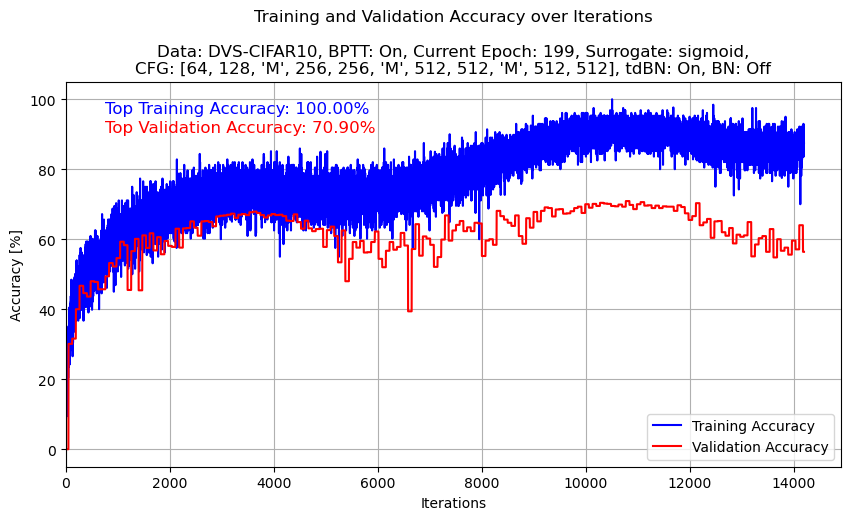

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def pad_array_to_match_length(array1, array2):
    if len(array1) > len(array2):
        padded_array2 = np.pad(array2, (0, len(array1) - len(array2)), 'constant')
        return array1, padded_array2
    elif len(array2) > len(array1):
        padded_array1 = np.pad(array1, (0, len(array2) - len(array1)), 'constant')
        return padded_array1, array2
    else:
        return array1, array2
def load_hyperparameters(filename='hyperparameters.json'):
    with open(filename, 'r') as f:
        return json.load(f)
    




current_time = '20240628_110116'
base_name = f'{current_time}'
train_acc_file_name = f'result_save/{base_name}_train_acc_array.npy'
val_acc_file_name = f'result_save/{base_name}_val_acc_now_array.npy'
hyperparameters_file_name = f'result_save/{base_name}_hyperparameters.json'

### if you want to just see most recent train and val acc###########################
train_acc_file_name = 'result_save/train_acc_array.npy'
val_acc_file_name = 'result_save/val_acc_now_array.npy'
hyperparameters_file_name = 'result_save/hyperparameters.json'

loaded_train_acc_array = np.load(train_acc_file_name)*100
loaded_val_acc_array = np.load(val_acc_file_name)*100
hyperparameters = load_hyperparameters(hyperparameters_file_name)

loaded_train_acc_array, loaded_val_acc_array = pad_array_to_match_length(loaded_train_acc_array, loaded_val_acc_array)
top_train_acc = hyperparameters['top_train_acc_one_iter']
top_val_acc = hyperparameters['top_val_acc']
which_data = hyperparameters['which_data']
BPTT_on = hyperparameters['BPTT_on']
current_epoch = hyperparameters['current epoch']
surrogate = hyperparameters['surrogate']
cfg = hyperparameters['cfg']
tdBN_on = hyperparameters['tdBN_on']
BN_on = hyperparameters['BN_on']


iterations = np.arange(len(loaded_train_acc_array))

# 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(iterations, loaded_train_acc_array, label='Training Accuracy', color='b')
plt.plot(iterations, loaded_val_acc_array, label='Validation Accuracy', color='r')

# 텍스트 추가
plt.text(0.05, 0.95, f'Top Training Accuracy: {100*top_train_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='blue')
plt.text(0.05, 0.90, f'Top Validation Accuracy: {100*top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='red')

plt.xlabel('Iterations')
plt.ylabel('Accuracy [%]')

# 그래프 제목에 하이퍼파라미터 정보 추가
title = f'Training and Validation Accuracy over Iterations\n\nData: {which_data}, BPTT: {"On" if BPTT_on else "Off"}, Current Epoch: {current_epoch}, Surrogate: {surrogate},\nCFG: {cfg}, tdBN: {"On" if tdBN_on else "Off"}, BN: {"On" if BN_on else "Off"}'

plt.title(title)

plt.legend(loc='lower right')
plt.xlim(0)  # x축을 0부터 시작
plt.grid(True)
plt.show()